In [4]:
train_dir = 'D:/Documentos/Estudio/Maestría/1-Periodo/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Train' 
val_dir = 'D:/Documentos/Estudio/Maestría/1-Periodo/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Val' 
test_dir = 'D:/Documentos/Estudio/Maestría/1-Periodo/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Test'

In [2]:
#ELEGIMOS LOS PARAMETROS
from keras.preprocessing.image import ImageDataGenerator
ih, iw = 256,256 #tamano de la imagen
input_shape = (ih, iw, 3) #forma de la imagen: alto ancho y numero de canales

num_class = 2 #cuantas clases 
#epochs = 15 #cuantas veces entrenar. En cada epoch hace una mejora en los parametros

batch_size = 32 #batch para hacer cada entrenamiento. Lee 50 'batch_size' imagenes antes de actualizar los parametros. Las carga a memoria
num_train = 21715 #numero de imagenes en train
num_test = 6788 #numero de imagenes en test
num_val=5417

epoch_steps = num_train // batch_size 
test_steps = num_test // batch_size
 

Using TensorFlow backend.


In [6]:
#LEEMOS LAS IMÁGENES 

img_height, img_width=ih, iw

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as training data

validation_generator = train_datagen.flow_from_directory(
    val_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

test_generator = train_datagen.flow_from_directory(
    test_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

Found 14507 images belonging to 2 classes.
Found 3615 images belonging to 2 classes.
Found 4535 images belonging to 2 classes.


In [7]:
train=train_generator
val=validation_generator
test=test_generator

In [8]:
from keras.applications import MobileNet
from keras.models import Model 
import keras 
import tensorflow as tf

mobilnet = tf.keras.applications.MobileNet(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

mobilnet.trainable=False

C:\Users\elium\.conda\envs\tfGPU\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [9]:
import pandas as pd 
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in mobilnet.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

C:\Users\elium\.conda\envs\tfGPU\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001E071EB4408>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001E0726E9E08>,conv1_pad,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001E071EB0908>,conv1,False
3,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000001E0726D0548>,conv1_bn,False
4,<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x000001E0720D0A88>,conv1_relu,False
...,...,...,...
82,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000001E0617D3B88>,conv_dw_13_bn,False
83,<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x000001E0617DA7C8>,conv_dw_13_relu,False
84,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001E0617DFA88>,conv_pw_13,False
85,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000001E061836A88>,conv_pw_13_bn,False


In [10]:
mobilnet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 257, 257, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 128, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 128, 128, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 128, 128, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 128, 128, 32

In [11]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [12]:
from os import listdir
from os.path import isfile,isdir, join
import numpy

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Dropout,Activation,MaxPooling2D,Flatten
from keras.optimizers import RMSprop 
from sklearn.model_selection import train_test_split

In [17]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer 
from keras.models import Sequential 
from keras import optimizers 

# build model architecture 
model = tf.keras.Sequential()
model.add(mobilnet)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(num_class, activation='sigmoid'))
#compile model
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
      metrics=['accuracy',f1_m,precision_m, recall_m])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 8, 8, 1024)        3228864   
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 131074    
Total params: 3,359,938
Trainable params: 131,074
Non-trainable params: 3,228,864
_________________________________________________________________
None


In [18]:
history = model.fit_generator(train, 
                              epochs=10,  
                              validation_data=val,  
                              verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 454 steps, validate for 113 steps
Epoch 1/10
454/454 [==============================] - 31s 69ms/step - loss: 0.4443 - accuracy: 0.8756 - f1_m: 0.8607 - precision_m: 0.8529 - recall_m: 0.8721 - val_loss: 0.4895 - val_accuracy: 0.8620 - val_f1_m: 0.7945 - val_precision_m: 0.8879 - val_recall_m: 0.7225
Epoch 2/10
454/454 [==============================] - 28s 63ms/step - loss: 0.3794 - accuracy: 0.9425 - f1_m: 0.9348 - precision_m: 0.9353 - recall_m: 0.9353 - val_loss: 0.4958 - val_accuracy: 0.8196 - val_f1_m: 0.7856 - val_precision_m: 0.8456 - val_recall_m: 0.7364
Epoch 3/10
454/454 [==============================] - 29s 63ms/step - loss: 0.3643 - accuracy: 0.9553 - f1_m: 0.9522 - precision_m: 0.9521 - recall_m: 0.9529 - val_loss: 0.5217 - val_accuracy: 0.7618 - val_f1_m: 0.7485 - val_precision_m: 0.7950 - val_recall_m: 0.7098
Epoch 4/10
454/454 [======

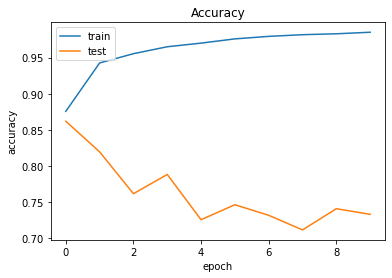

In [19]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

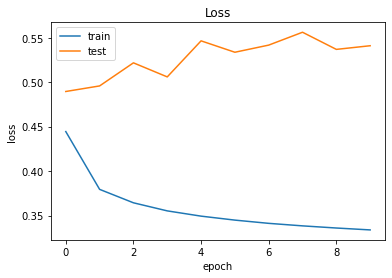

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

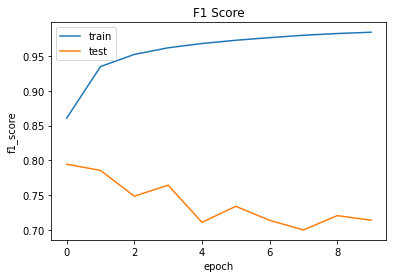

In [21]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

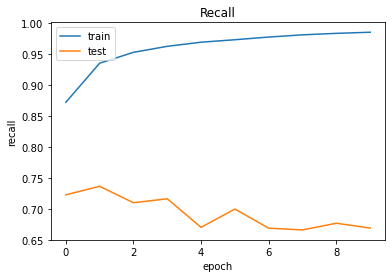

In [22]:
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

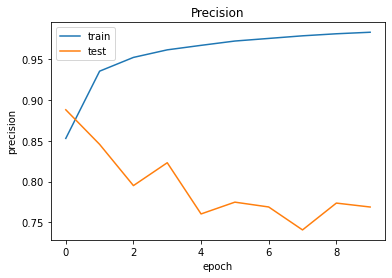

In [23]:
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('Precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
print('Utilizando el conjunto de datos de test para evaluar el modelo')
test_eval = model.evaluate(test, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

Utilizando el conjunto de datos de test para evaluar el modelo
  ...
    to  
  ['...']
142/142 [==============================] - 7s 52ms/step - loss: 0.5172 - accuracy: 0.7768 - f1_m: 0.7475 - precision_m: 0.8074 - recall_m: 0.6979
El modelo predice el  77.68467664718628 % de los datos


In [25]:
print('Utilizando el conjunto de datos de test para evaluar el modelo')
print('Loss: ',test_eval[0])
print('Accuracy: ',test_eval[1])
print('F1 Score: ',test_eval[2])
print('Precision: ',test_eval[3])
print('Recall: ',test_eval[4])

Utilizando el conjunto de datos de test para evaluar el modelo
Loss:  0.517170037182284
Accuracy:  0.77684677
F1 Score:  0.7474906
Precision:  0.80741686
Recall:  0.69785285
